In [14]:
# 기본 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 그래프 기본 테마 설정
# https://coldbrown.co.kr/2023/07/%ED%8C%8C%EC%9D%B4%EC%8D%AC-%EC%8B%A4%EC%A0%84%ED%8E%B8-08-seaborn-sns-set%EC%9D%84-%ED%86%B5%ED%95%B4-%EC%8A%A4%ED%83%80%EC%9D%BC-%EC%84%A4%EC%A0%95%ED%95%98%EA%B8%B0/
sns.set()

# 그래프 기본 설정
# plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 복잡한 통계 처리를 위한 라이브러리
from scipy import stats

### 데이터 불러오기

In [15]:
df = pd.read_csv('../Pizza Sales Dataset.csv')
df

,pizza_id,order_id,pizza_name_id,quantity,order_date,order_day,order_time,unit_price,total_price,pizza_size,pizza_category,pizza_ingredients,pizza_name
0,1,1,hawaiian_m,1,1/1/2015,Thursday,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,Thursday,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,Thursday,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,Thursday,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,Thursday,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,12/31/2015,Thursday,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza
48616,48617,21348,four_cheese_l,1,12/31/2015,Thursday,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
48617,48618,21348,napolitana_s,1,12/31/2015,Thursday,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
48618,48619,21349,mexicana_l,1,12/31/2015,Thursday,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [16]:
df.columns

Index(['pizza_id', 'order_id', 'pizza_name_id', 'quantity', 'order_date',
       'order_day', 'order_time', 'unit_price', 'total_price', 'pizza_size',
       'pizza_category', 'pizza_ingredients', 'pizza_name'],
      dtype='object')

### 컬럼명 한국어로 바꾸기

In [17]:
df.rename(columns={
    'pizza_id': '피자 ID',
    'order_id': '주문 ID',
    'pizza_name_id': '피자 이름 ID',
    'quantity': '주문 수량',
    'order_date': '주문 날짜',
    'order_day': '주문 요일',
    'order_time': '주문 시간',
    'unit_price': '단가',
    'total_price': '총액',
    'pizza_size': '피자 사이즈',
    'pizza_category': '피자 종류',
    'pizza_ingredients': '피자 재료 목록',
    'pizza_name': '피자 이름'
}, inplace=True)

df

,피자 ID,주문 ID,피자 이름 ID,주문 수량,주문 날짜,주문 요일,주문 시간,단가,총액,피자 사이즈,피자 종류,피자 재료 목록,피자 이름
0,1,1,hawaiian_m,1,1/1/2015,Thursday,11:38:36,13.25,13.25,M,Classic,"Sliced Ham, Pineapple, Mozzarella Cheese",The Hawaiian Pizza
1,2,2,classic_dlx_m,1,1/1/2015,Thursday,11:57:40,16.00,16.00,M,Classic,"Pepperoni, Mushrooms, Red Onions, Red Peppers,...",The Classic Deluxe Pizza
2,3,2,five_cheese_l,1,1/1/2015,Thursday,11:57:40,18.50,18.50,L,Veggie,"Mozzarella Cheese, Provolone Cheese, Smoked Go...",The Five Cheese Pizza
3,4,2,ital_supr_l,1,1/1/2015,Thursday,11:57:40,20.75,20.75,L,Supreme,"Calabrese Salami, Capocollo, Tomatoes, Red Oni...",The Italian Supreme Pizza
4,5,2,mexicana_m,1,1/1/2015,Thursday,11:57:40,16.00,16.00,M,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48615,48616,21348,ckn_alfredo_m,1,12/31/2015,Thursday,21:23:10,16.75,16.75,M,Chicken,"Chicken, Red Onions, Red Peppers, Mushrooms, A...",The Chicken Alfredo Pizza
48616,48617,21348,four_cheese_l,1,12/31/2015,Thursday,21:23:10,17.95,17.95,L,Veggie,"Ricotta Cheese, Gorgonzola Piccante Cheese, Mo...",The Four Cheese Pizza
48617,48618,21348,napolitana_s,1,12/31/2015,Thursday,21:23:10,12.00,12.00,S,Classic,"Tomatoes, Anchovies, Green Olives, Red Onions,...",The Napolitana Pizza
48618,48619,21349,mexicana_l,1,12/31/2015,Thursday,22:09:54,20.25,20.25,L,Veggie,"Tomatoes, Red Peppers, Jalapeno Peppers, Red O...",The Mexicana Pizza


In [36]:
df['피자 이름'].value_counts()

피자 이름
The Classic Deluxe Pizza                      2416
The Barbecue Chicken Pizza                    2372
The Hawaiian Pizza                            2370
The Pepperoni Pizza                           2369
The Thai Chicken Pizza                        2315
The California Chicken Pizza                  2302
The Sicilian Pizza                            1887
The Spicy Italian Pizza                       1887
The Southwest Chicken Pizza                   1885
The Four Cheese Pizza                         1850
The Italian Supreme Pizza                     1849
The Big Meat Pizza                            1811
The Vegetables + Vegetables Pizza             1510
The Mexicana Pizza                            1456
The Napolitana Pizza                          1451
The Spinach and Feta Pizza                    1432
The Prosciutto and Arugula Pizza              1428
The Pepper Salami Pizza                       1422
The Italian Capocollo Pizza                   1414
The Greek Pizza          

In [18]:
# 결측치 확인 : 없음
df.isna().sum()

피자 ID       0
주문 ID       0
피자 이름 ID    0
주문 수량       0
주문 날짜       0
주문 요일       0
주문 시간       0
단가          0
총액          0
피자 사이즈      0
피자 종류       0
피자 재료 목록    0
피자 이름       0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48620 entries, 0 to 48619
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   피자 ID     48620 non-null  int64  
 1   주문 ID     48620 non-null  int64  
 2   피자 이름 ID  48620 non-null  object 
 3   주문 수량     48620 non-null  int64  
 4   주문 날짜     48620 non-null  object 
 5   주문 요일     48620 non-null  object 
 6   주문 시간     48620 non-null  object 
 7   단가        48620 non-null  float64
 8   총액        48620 non-null  float64
 9   피자 사이즈    48620 non-null  object 
 10  피자 종류     48620 non-null  object 
 11  피자 재료 목록  48620 non-null  object 
 12  피자 이름     48620 non-null  object 
dtypes: float64(2), int64(3), object(8)
memory usage: 4.8+ MB


### 분석 시작

### EDA

 ### 🍕주문 ID가 같은 사용자 중(한번에 여러판 주문) 같이 주문하는 피자의 조합 중 BEST 5를 뽑아보자.

In [34]:
# 미리 알아두어야 할 것.. 한 판 씩 시킨 주문이 압도적으로 많음

# 두 종류 이상의 피자가 같이 주문 된 경우만 필터링
# multi_combi : 한번에 두 판 이상 시킨 주문 data
df_subset = df[['주문 ID', '피자 이름']]
order_combi = df_subset.groupby('주문 ID')['피자 이름'].apply(list)
order_combi = order_combi.apply(lambda x: tuple(sorted(x)))
multi_combi = order_combi[order_combi.apply(lambda x: len(x) > 1)]

from collections import Counter
multi_combi_counter = Counter(multi_combi)
top3_multi_combi = multi_combi_counter.most_common(5)

top3_multi_combi_df = pd.DataFrame(top3_multi_combi, columns = ['피자조합', "빈도수"])
display(top3_multi_combi_df)

# top3_multi_combi_df.to_csv('한번에 함께 주문된 피자조합 top5', index = False)

,피자조합,빈도수
0,"(The Pepperoni Pizza, The Thai Chicken Pizza)",39
1,"(The California Chicken Pizza, The Thai Chicke...",38
2,"(The Classic Deluxe Pizza, The Hawaiian Pizza)",38
3,"(The Barbecue Chicken Pizza, The California Ch...",36
4,"(The Barbecue Chicken Pizza, The Classic Delux...",35


/var/folders/sd/4fdm4yws541djlmflm16vjv40000gn/T/ipykernel_97880/1928561013.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


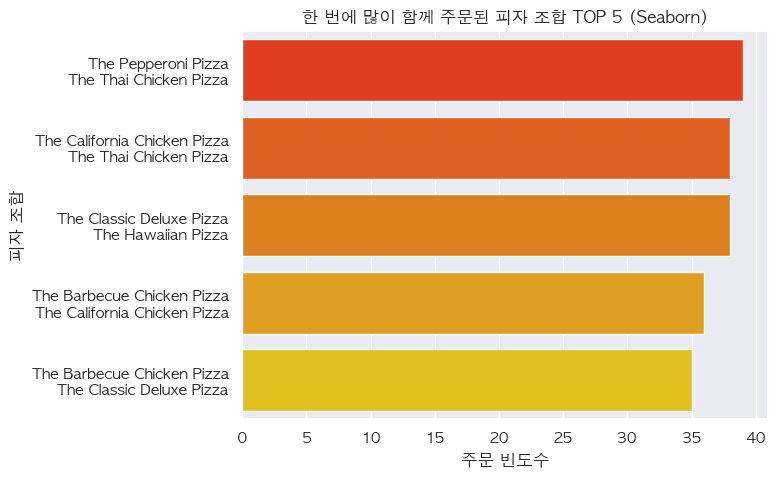

In [25]:
# 튜플을 보기 좋게 문자열로 바꾸기 (예: 피자1\n피자2)
top3_multi_combi_df["피자조합_이름"] = top3_multi_combi_df["피자조합"].apply(lambda x: "\n".join(x))

# seaborn 불러오기
import seaborn as sns

# seaborn을 사용한 가로 막대 그래프 시각화
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top3_multi_combi_df,
    y="피자조합_이름",
    x="빈도수",
    palette="autumn"
)

plt.xlabel("주문 빈도수")
plt.ylabel("피자 조합")
plt.title("한 번에 함께 주문된 피자 조합 TOP 5 (Seaborn)")
plt.tight_layout()
plt.show()

---------------------------------------------------------------------------------

### **🕹️가격대별 고객 취향 세분화 (클러스터링 유사 접근)**

- **목표**: 고객들은 어떤 가격대 + 어떤 종류의 피자를 즐기는가?
- **시각화**: `unit_price`, `category`, `size` 기준 버블 차트
- **활용**: 타깃 고객별 맞춤 프로모션 (ex. 저가+소형 선호 고객층 vs 고가+XL 고객층)

In [35]:
# 가격 구간화 

def 가격구간(가격):
    if 가격 <= 14.99:
        return '저가 (≤ $14.99)'
    elif 15.00 <= 가격 <= 19.99:
        return '중가 ($15.00 ~ $19.99)'
    else:
        return '고가 (≥ $20.00)'

# 단가 기준으로 구간 분류
df['가격 구간'] = df['단가'].apply(가격구간)

# 가격 구간 + 피자 종류별 수량 합계
grouped = df.groupby(['가격 구간', '피자 종류'])['주문 수량'].sum().reset_index()

# 각 가격 구간에서 총 수량 기준으로 비율 계산
grouped['비율'] = grouped.groupby('가격 구간')['주문 수량'].transform(lambda x: round(x / x.sum(), 2))
grouped

grouped.to_csv('가격대별 피자 종류 분석', index = False, encoding = 'utf-8-sig')

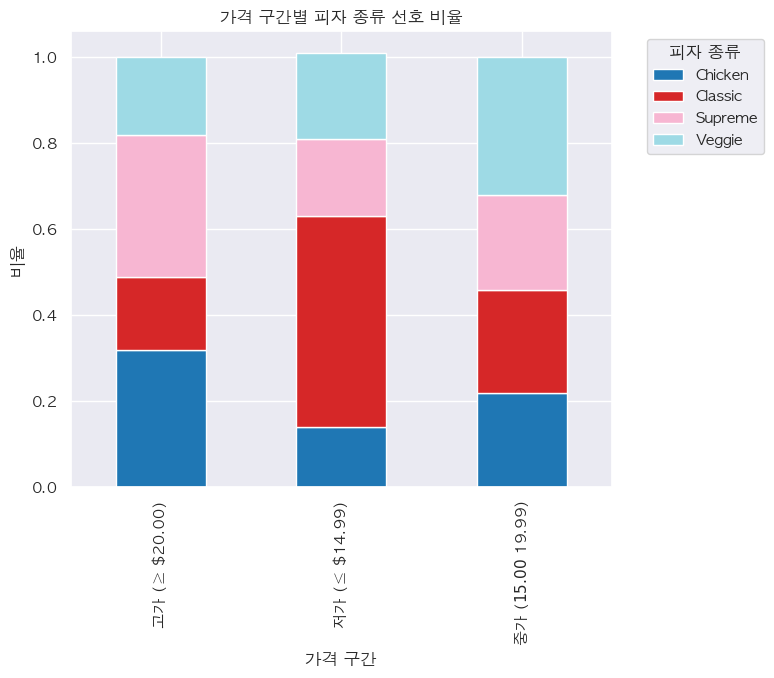

In [27]:
# 누적 barplot으로 그려보기

pivot_df = grouped.pivot(index='가격 구간', columns='피자 종류', values='비율')

pivot_df.plot(kind='bar', stacked=True, figsize=(8, 7), colormap='tab20')
plt.title('가격 구간별 피자 종류 선호 비율')
plt.ylabel('비율')
plt.xlabel('가격 구간')
plt.legend(title='피자 종류', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


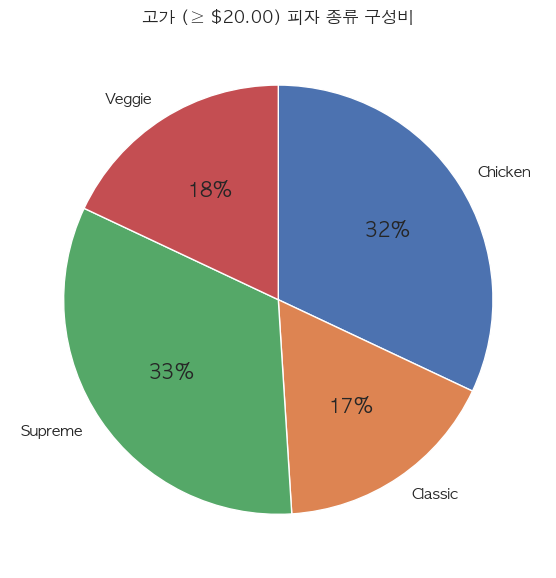

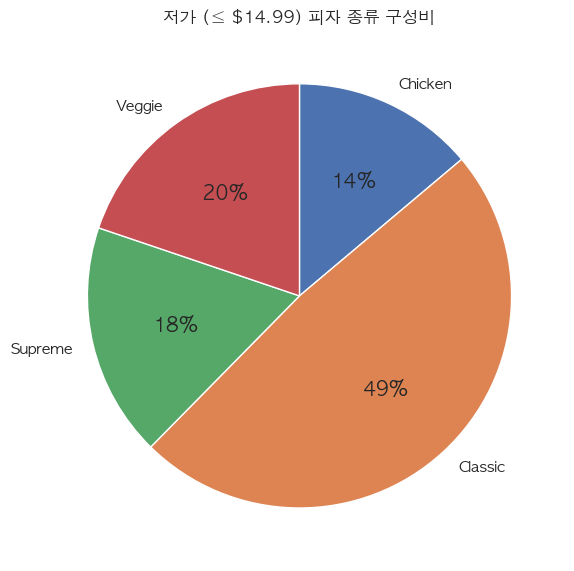

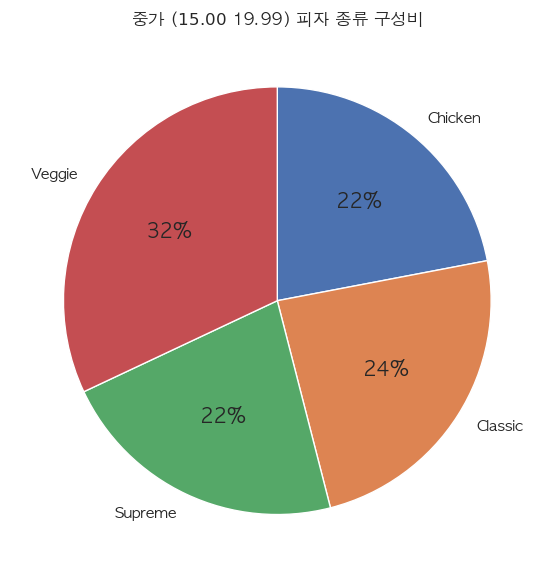

In [28]:
# 파이그래프로 그려보기
import matplotlib.pyplot as plt

# 각 가격 구간에 대해 pie chart 반복 생성
구간_리스트 = grouped['가격 구간'].unique()

for 구간 in 구간_리스트:
    # 현재 구간의 데이터 필터링
    temp = grouped[grouped['가격 구간'] == 구간]

    labels = temp['피자 종류']
    sizes = temp['비율']  # 이미 0~1 사이 비율로 되어 있음

    # 차트 생성
    plt.figure(figsize=(6, 6))
    plt.pie(
        sizes, 
        labels=labels, 
        autopct='%1.0f%%', 
        startangle=90, 
        counterclock=False, 
        wedgeprops={'edgecolor': 'white'}
    )
    plt.title(f"{구간} 피자 종류 구성비")
    plt.tight_layout()
    plt.show()


**🔍 인사이트 정리 (보고서/발표용)**

✅ 1. 저가 구간 (≤ $14.99)
Classic 피자 비중 압도적 (~50%)

그 외에는 Supreme, Chicken이 균형 있게 분포

📝 인사이트:

저가 라인은 "전통적인 입맛" 중심. Classic 피자를 중심으로 단일 인기 메뉴 전략이 가능. 원가 절감형 베스트셀러 구성에 적합.

✅ 2. 중가 구간 ($15.00 ~ $19.99)
4가지 종류가 골고루 분포
(Chicken, Classic, Supreme, Veggie 균형 잡힘)

📝 인사이트:

중가 라인은 취향 다양성이 극대화된 구간. 모든 카테고리 피자를 고르게 즐김 → 콤보 메뉴, 혼합 패키지, 커스터마이징 옵션 강화에 적합.

✅ 3. 고가 구간 (≥ $20.00)
Chicken 비율 상승, Classic 감소

Veggie/Supreme도 고르게 유지

📝 인사이트:

고가 피자는 육류 중심의 프리미엄 취향이 뚜렷함. Chicken 피자에 대한 선호가 확연히 드러남. 고단백/고급 토핑 기반 프리미엄 라인 확장 가능.

---------------------------------------------------------------------------------

### **🧄토핑 종류 다양성과 단가 관계 분석 수연님**

- 목표: 토핑이 많을수록 가격이 비쌀까?
- 전처리: Toppings 개수 계산 → Unit Price와 관계 산점도
- 활용: 토핑 추가 가격 정책 검토

In [29]:
# 토핑 문자열을 , 기준으로 분리한 후 개수 계산
df['토핑 수'] = df['피자 재료 목록'].apply(lambda x: len(x.split(',')))

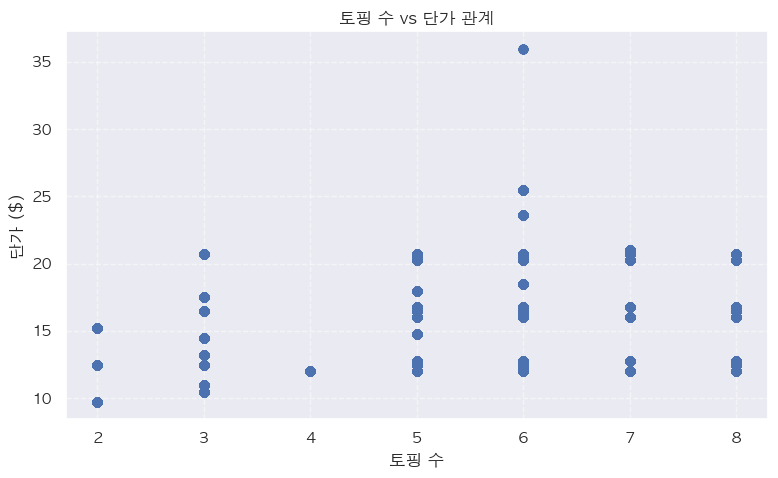

In [30]:
# 단가와 토핑수를 산점도로 나타내기

plt.figure(figsize=(8, 5))
plt.scatter(df['토핑 수'], df['단가'], alpha=0.6)
plt.title('토핑 수 vs 단가 관계')
plt.xlabel('토핑 수')
plt.ylabel('단가 ($)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [31]:
corr = df[['토핑 수', '단가']].corr().iloc[0, 1]
print(f"토핑 수와 단가 간 상관계수: {corr:.2f}")

토핑 수와 단가 간 상관계수: 0.35


**📌 분석 요약**

X축: 피자당 토핑 수 (2~8개)

Y축: 해당 피자의 단가 ($)

상관계수: 0.35 → 약한~중간 정도의 양의 상관관계

**🔍 데이터 인사이트**

✅ 1. 토핑 수가 많을수록 가격이 오르는 경향
대체로 토핑 수 5~7개일 때 단가가 높은 피자들이 많음

**최고가 피자($35 이상)**도 토핑 6개인 구간에서 등장

✅ 2. 예외 케이스 존재
토핑 수 5~6개지만 단가가 낮은 피자 존재

토핑 수 2~3개임에도 단가가 높은 피자도 일부 존재 → 브랜드 전략 또는 고급 재료 가능성

💬 인사이트 요약 문장 (보고서용)
“토핑 수와 단가는 중간 정도의 양의 상관관계를 보이며, 일반적으로 토핑이 많을수록 가격이 높아지는 경향이 있습니다. 다만 일부 토핑 수가 적어도 가격이 높은 제품이 존재하며, 이는 브랜드 가치나 프리미엄 원재료 사용 등의 요인이 반영된 것으로 해석됩니다.”